# Livingston Time Lagged Guidance

Calculate the reliability of ProbGust, and previous guidance.

## Import modules

In [1]:
import xarray            as xr
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import seaborn           as sns
import scipy.stats       as stats
import pint

## Set some contants

In [2]:
sns.set_theme(color_codes=True)
units = pint.UnitRegistry()
hour = pd.to_timedelta('1H')
normal_distribution = stats.norm()

## Define utility functions

### correction
Apply operational correction to the time-lagged NAM proability for 6S0

def correction(criteria, value):
    new_value = value
    if criteria == 50:
        if value < 5:
            new_value = 1
        elif (5 <= value) and (value < 10):
            new_value = 9
        elif (10 <= value) and (value < 20):
            new_value = 19
        elif (20 <= value) and (value < 30):
            new_value = 31
        elif (30 <= value) and (value < 40):
            new_value = 43
        elif (40 <= value) and (value < 50):
            new_value = 58
        else:
            new_value = 73
    elif criteria == 58:
        if value < 5:
            new_value = 0
        elif (5 <= value) and (value < 10):
            new_value = 1
        elif (10 <= value) and (value < 20):
            new_value = 2
        elif (20 <= value) and (value < 30):
            new_value = 6
        elif (30 <= value) and (value < 40):
            new_value = 10
        elif (40 <= value) and (value < 50):
            new_value = 15
        else:
            new_value = 26
    elif criteria == 70:
        if value < 5:
            new_value = 0
        elif (5 <= value) and (value < 10):
            new_value = 0
        elif (10 <= value) and (value < 20):
            new_value = 0
        elif (20 <= value) and (value < 30):
            new_value = 0
        elif (30 <= value) and (value < 40):
            new_value = 1
        elif (40 <= value) and (value < 50):
            new_value = 3
        else:
            new_value = 5
    return new_value

### expand_timelag
Duplicate a dataframe while adjusting a datetime field by an interval to create a time-lagged dataset

In [3]:
def expand_timelag(df, interval, field='reference_time'):
    df2 = df.copy(deep=True).reset_index()
    df2[field] += pd.to_timedelta(interval)
    return df2

## Load Operation Probability Guidance

In [4]:
previous = xr.open_dataset('../data/database/MOSDATA.nc').to_dataframe()
previous = previous[(previous.stn == 'KLVM') & (previous.model == 'MAV') & np.isfinite(previous.run) & np.isfinite(previous.valid) & (previous.valid >= pd.to_datetime('2020-09-30T18:00:00Z').to_datetime64())][['run', 'valid', 'WDR', 'WSP']].set_index(['run', 'valid']).sort_index()

subadvisory_matrix = xr.open_dataset('../data/database/LVMSubmatrix_MAV.nc').to_dataframe()
advisory_matrix = xr.open_dataset('../data/database/LVMmatrix.nc').to_dataframe()
warning_matrix = xr.open_dataset('../data/database/LVMWarnmatrix.nc').to_dataframe()

previous['MaxSub'] = pd.merge(right=previous.reset_index(), left=subadvisory_matrix.groupby(['WindDirection']).WindSpeed.max().reset_index(), right_on='WDR', left_on='WindDirection', how='right').set_index(['run', 'valid']).sort_index()['WindSpeed']
previous.MaxSub= previous.MaxSub.fillna(999)

previous['MaxAdv'] = pd.merge(right=previous.reset_index(), left=advisory_matrix.groupby(['WindDirection']).WindSpeed.max().reset_index(), right_on='WDR', left_on='WindDirection', how='right').set_index(['run', 'valid']).sort_index()['WindSpeed']
previous.MaxAdv = previous.MaxAdv.fillna(999)

previous['MaxWarn'] = pd.merge(right=previous.reset_index(), left=warning_matrix.groupby(['DIR']).WS.max().reset_index(), right_on='WDR', left_on='DIR', how='right').set_index(['run', 'valid']).sort_index()['WS']
previous.MaxWarn = previous.MaxWarn.fillna(999)

previous['SubSpeed'] = previous[['WSP', 'MaxSub']].apply(lambda a: a.min(), axis=1)
previous['Raw_50'] = pd.merge(right=previous.reset_index(), left=subadvisory_matrix, right_on=['WDR', 'SubSpeed'], left_on=['WindDirection', 'WindSpeed'], how='right').groupby(['run', 'valid'])['Probability'].max()
previous.Raw_50 = previous.Raw_50.fillna(0)

previous['AdvSpeed'] = previous[['WSP', 'MaxAdv']].apply(lambda a: a.min(), axis=1)
previous['Raw_58'] = pd.merge(right=previous.reset_index(), left=advisory_matrix, right_on=['WDR', 'AdvSpeed'], left_on=['WindDirection', 'WindSpeed'], how='right').groupby(['run', 'valid'])['Probability'].max()
previous.Raw_58 = previous.Raw_58.fillna(0)

previous['WarnSpeed'] = previous[['WSP', 'MaxWarn']].apply(lambda a: a.min(), axis=1)
previous['Raw_75'] = pd.merge(right=previous.reset_index(), left=warning_matrix, right_on=['WDR', 'WarnSpeed'], left_on=['DIR', 'WS'], how='right').groupby(['run', 'valid'])['Prob'].max()
previous.Raw_75 = previous.Raw_75.fillna(0)

previous = previous.reset_index()[['run', 'valid', 'Raw_50', 'Raw_58', 'Raw_75']]
previous.columns = ['reference_time', 'valid_time', 'Raw_50', 'Raw_58', 'Raw_75']
previous = previous.set_index(['reference_time', 'valid_time']).sort_index()

previous[[x.replace('Raw', 'Operational') for x in ['Raw_50', 'Raw_58', 'Raw_75']]] = pd.concat([expand_timelag(previous, '{0:d}H'.format(i*6)) for i in range(12)]).groupby(['reference_time', 'valid_time']).mean()[['Raw_50', 'Raw_58', 'Raw_75']]
#previous.groupby(level='reference_time').apply(lambda s: s.rolling(window=12, min_periods=1).mean())[['Raw_50', 'Raw_58', 'Raw_75']]

previous

Raw_50  Raw_58  Raw_75  \
reference_time      valid_time                                    
2020-09-27 18:00:00 2020-09-30 18:00:00     0.0     0.0     0.0   
2020-09-28 00:00:00 2020-09-30 18:00:00     0.0     0.0     0.0   
                    2020-10-01 00:00:00     0.0     0.0     0.0   
2020-09-28 06:00:00 2020-09-30 18:00:00     0.0     0.0     0.0   
                    2020-10-01 00:00:00     0.0     0.0     0.0   
...                                         ...     ...     ...   
2021-04-19 18:00:00 2021-04-22 00:00:00     0.0     0.0     0.0   
                    2021-04-22 03:00:00     0.0     0.0     0.0   
                    2021-04-22 06:00:00     2.0     0.0     0.0   
                    2021-04-22 12:00:00     0.0     0.0     0.0   
                    2021-04-22 18:00:00     0.0     0.0     0.0   

                                         Operational_50  Operational_58  \
reference_time      valid_time                                            
2020-09-27 18:00:00 2020-09-30 18:00:00        0.000000             0.0   
2020-09-28 00:00:00 2020-09-30 18:00:00        0.000000             0.0   
                    2020-10-01 00:00:00        0.000000             0.0   
2020-09-28 06:00:00 2020-09-30 18:00:00        0.000000             0.0   
                    2020-10-01 00:00:00        0.000000             0.0   
...                                                 ...             ...   
2021-04-19 18:00:00 2021-04-22 00:00:00        0.000000             0.0   
                    2021-04-22 03:00:00        0.000000             0.0   
                    2021-04-22 06:00:00        0.666667             0.0   
                    2021-04-22 12:00:00        0.000000             0.0   
                    2021-04-22 18:00:00        0.000000             0.0   

                                         Operational_75  
reference_time      valid_time                           
2020-09-27 18:00:00 2020-09-30 18:00:00             0.0  
2020-09-28 00:00:00 2020-09-30 18:00:00             0.0  
                    2020-10-01 00:00:00             0.0  
2020-09-28 06:00:00 2020-09-30 18:00:00             0.0  
                    2020-10-01 00:00:00             0.0  
...                                                 ...  
2021-04-19 18:00:00 2021-04-22 00:00:00             0.0  
                    2021-04-22 03:00:00             0.0  
                    2021-04-22 06:00:00             0.0  
                    2021-04-22 12:00:00             0.0  
                    2021-04-22 18:00:00             0.0  

[16755 rows x 6 columns]

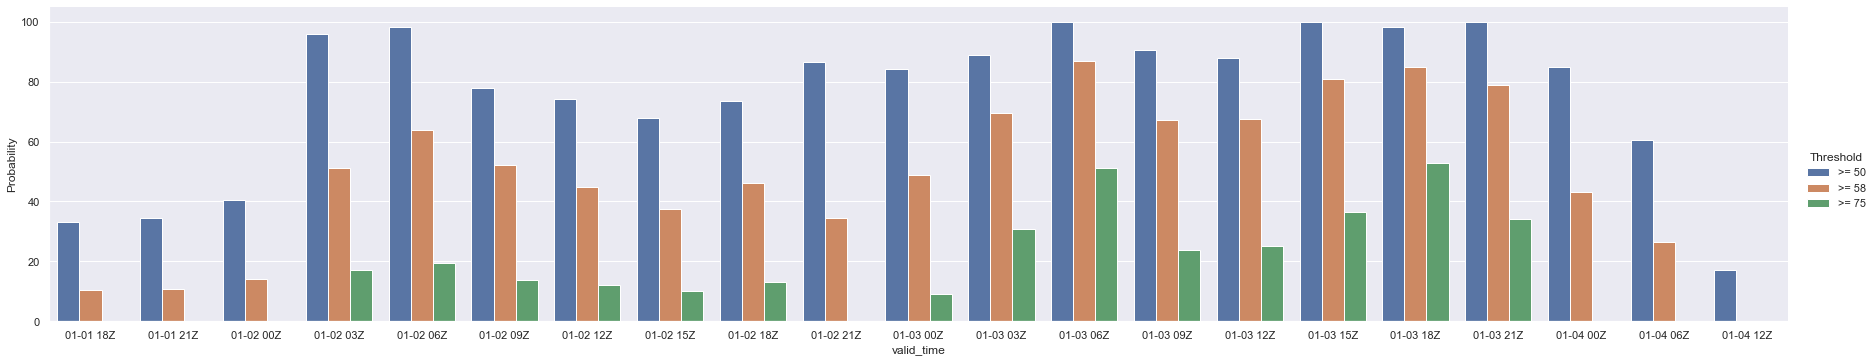

In [5]:
start = pd.to_datetime('2021-01-01T12:00:00Z')
end = start + pd.to_timedelta('3D')
run = previous[(previous.index.get_level_values(0) == start.to_datetime64()) * (previous.index.get_level_values(1) <= end.to_datetime64())].reset_index()
run = run[[x for x in run.columns if x.find('Operational') > -1 or x == 'valid_time']]
run.columns = [x.replace('Operational_', '>= ') for x in run.columns]
run = run.melt(id_vars='valid_time', value_name="Probability", var_name="Threshold")
run.valid_time = run.valid_time.dt.strftime('%m-%d %HZ')
g = sns.catplot(data=run, x='valid_time', y='Probability', hue='Threshold', kind='bar', aspect=5)
